In [1]:
import joblib
outs = joblib.load("outputs/artifacts/algo1_outs_2025-05-22_1min_agreg.pkl")

/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/1000  Train NLL: 6.1575e+00  Test NLL: 3.3948e+00
Epoch 2/1000  Train NLL: 5.9438e+00  Test NLL: 3.2128e+00
Epoch 3/1000  Train NLL: 5.7697e+00  Test NLL: 3.0618e+00
Epoch 4/1000  Train NLL: 5.6194e+00  Test NLL: 2.9322e+00
Epoch 5/1000  Train NLL: 5.4897e+00  Test NLL: 2.8230e+00
Epoch 6/1000  Train NLL: 5.3792e+00  Test NLL: 2.7326e+00
Epoch 7/1000  Train NLL: 5.2819e+00  Test NLL: 2.6579e+00
Epoch 8/1000  Train NLL: 5.1960e+00  Test NLL: 2.5948e+00
Epoch 9/1000  Train NLL: 5.1202e+00  Test NLL: 2.5459e+00
Epoch 10/1000  Train NLL: 5.0553e+00  Test NLL: 2.5102e+00
Epoch 11/1000  Train NLL: 5.0019e+00  Test NLL: 2.4859e+00
Epoch 12/1000  Train NLL: 4.9564e+00  Test NLL: 2.4654e+00
Epoch 13/1000  Train NLL: 4.9116e+00  Test NLL: 2.4425e+00
Epoch 14/1000  Train NLL: 4.8648e+00  Test NLL: 2.4173e+00
Epoch 15/1000  Train NLL: 4.8182e+00  Test NLL: 2.3946e+00
Epoch 16/1000  Train NLL: 4.7732e+00  Test NLL: 2.3724e+00
Epoch 17/1000  Train NLL: 4.7288e+00  Test NLL: 2.3503e+00
Epoch 

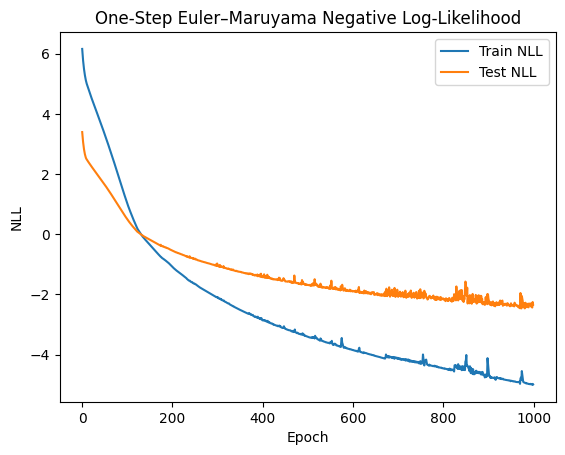

In [2]:
from neural_sde.loss import likelihood_training
train_losses, test_losses, model, X_train = likelihood_training(
    outs,
    n_epochs=1000,
    batch_size=256,
    lr=1e-4,
    data='xi',
    zero_drift=False
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [3]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sec_per_year = 365*24*60*60

# 1) Build dt arrays (seconds and years)
tt_tr = pd.to_datetime(outs.C_train.index.values)  # [`pipeline.Algo1Outputs.C_train`](pipeline/algo1.py)
tt_te = pd.to_datetime(outs.C_test.index.values)   # [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py)

# Differences as Timedeltas, then robustly convert to NumPy float seconds
dt_tr_td = tt_tr[1:] - tt_tr[:-1]
dt_te_td = tt_te[1:] - tt_te[:-1]

dt_tr_s = np.asarray(pd.to_timedelta(dt_tr_td).total_seconds(), dtype=np.float64)
dt_te_s = np.asarray(pd.to_timedelta(dt_te_td).total_seconds(), dtype=np.float64)

dt_tr_y = dt_tr_s / sec_per_year
dt_te_y = dt_te_s / sec_per_year

# 2) Text summary
def summarize_dt(name, dt_s):
    dt_s = np.asarray(dt_s, dtype=np.float64)
    q = np.quantile(dt_s, [0,.01,.05,.25,.5,.75,.95,.99,1.0])
    print(f"{name}: pairs={dt_s.size}  mean={np.mean(dt_s):.2f}s  std={np.std(dt_s):.2f}s  median={q[4]:.2f}s")
    print(f"  quantiles (s): 0%={q[0]:.2f}, 1%={q[1]:.2f}, 5%={q[2]:.2f}, 25%={q[3]:.2f}, "
          f"50%={q[4]:.2f}, 75%={q[5]:.2f}, 95%={q[6]:.2f}, 99%={q[7]:.2f}, 100%={q[8]:.2f}")
    for thr in (1, 5, 10, 60, 300, 900):
        frac = float((dt_s > thr).mean())
        print(f"  frac(dt > {thr:>3}s) = {frac:6.2%}")

summarize_dt("Train Δt", dt_tr_s)
summarize_dt("Test  Δt", dt_te_s)

# 3) Plots: histogram (seconds) and ECDF
p99 = max(np.quantile(dt_tr_s, 0.99), np.quantile(dt_te_s, 0.99))
bins = np.linspace(0, p99, 60)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.6))

# Histogram up to 99th percentile (seconds)
axes[0].hist(dt_tr_s, bins=bins, alpha=0.5, label="train")
axes[0].hist(dt_te_s, bins=bins, alpha=0.5, label="test")
axes[0].set_title("Δt histogram (seconds, up to 99th pct)")
axes[0].set_xlabel("Δt [s]"); axes[0].set_ylabel("count"); axes[0].legend()

# ECDF (years) for full range
def ecdf(x):
    x = np.sort(np.asarray(x, dtype=np.float64))
    y = np.linspace(0, 1, len(x), endpoint=False)
    return x, y

x_tr, y_tr = ecdf(dt_tr_y); x_te, y_te = ecdf(dt_te_y)
axes[1].plot(x_tr, y_tr, label="train")
axes[1].plot(x_te, y_te, label="test")
axes[1].set_title("Δt ECDF (years)")
axes[1].set_xlabel("Δt [years]"); axes[1].set_ylabel("F(Δt)"); axes[1].legend(loc="lower right")

plt.tight_layout(); plt.show()

Train Δt: pairs=1100  mean=60.00s  std=0.00s  median=60.00s
  quantiles (s): 0%=60.00, 1%=60.00, 5%=60.00, 25%=60.00, 50%=60.00, 75%=60.00, 95%=60.00, 99%=60.00, 100%=60.00
  frac(dt >   1s) = 100.00%
  frac(dt >   5s) = 100.00%
  frac(dt >  10s) = 100.00%
  frac(dt >  60s) =  0.00%
  frac(dt > 300s) =  0.00%
  frac(dt > 900s) =  0.00%
Test  Δt: pairs=339  mean=60.00s  std=0.00s  median=60.00s
  quantiles (s): 0%=60.00, 1%=60.00, 5%=60.00, 25%=60.00, 50%=60.00, 75%=60.00, 95%=60.00, 99%=60.00, 100%=60.00
  frac(dt >   1s) = 100.00%
  frac(dt >   5s) = 100.00%
  frac(dt >  10s) = 100.00%
  frac(dt >  60s) =  0.00%
  frac(dt > 300s) =  0.00%
  frac(dt > 900s) =  0.00%


In [4]:
# In your neural_sde.ipynb after training
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

sde_model = model

# 1) In-sample factor matrix (columns = factors: dyn | stat | sa)
X_train, _, names = build_xi_training_data(outs)  # names like ["dyn0","dyn1",...,"stat0",...,"sa0",...]

# 2) Compute dt in years from training timestamps (align lengths)
tt = pd.to_datetime(outs.C_train.index.values)
# sec_per_year = 1
dt = np.asarray((tt[1:] - tt[:-1]).total_seconds(), dtype=np.float64) / sec_per_year

L = min(len(dt), X_train.shape[0]-1)

device = next(sde_model.parameters()).device
Y0 = torch.from_numpy(X_train[:L]).float().to(device)
Y1 = torch.from_numpy(X_train[1:L+1]).float().to(device)
dt_t = torch.from_numpy(dt[:L].copy()).float().unsqueeze(1).clamp_min(1e-12).to(device)

with torch.no_grad():
    mu  = sde_model.f(0.0, Y0)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 3) One-step standardized residuals under the trained SDE
#    ε_t = (x_{t+1} - x_t - f(x_t)Δt) / (g(x_t)√Δt)
with torch.no_grad():
    mu = sde_model.f(0.0, Y0)                        # [`neural_sde.nets.NeuralSDE.f`](neural_sde/nets.py)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)       # [`neural_sde.nets.NeuralSDE.g`](neural_sde/nets.py)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 4) QQ plots per factor
d = resid.shape[1]
cols = 3
rows = int(np.ceil(d/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2))
axes = axes.ravel()

for j in range(d):
    stats.probplot(resid[:, j], dist="norm", plot=axes[j])
    axes[j].set_title(names[j] if names else f"factor {j}")

for k in range(d, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()



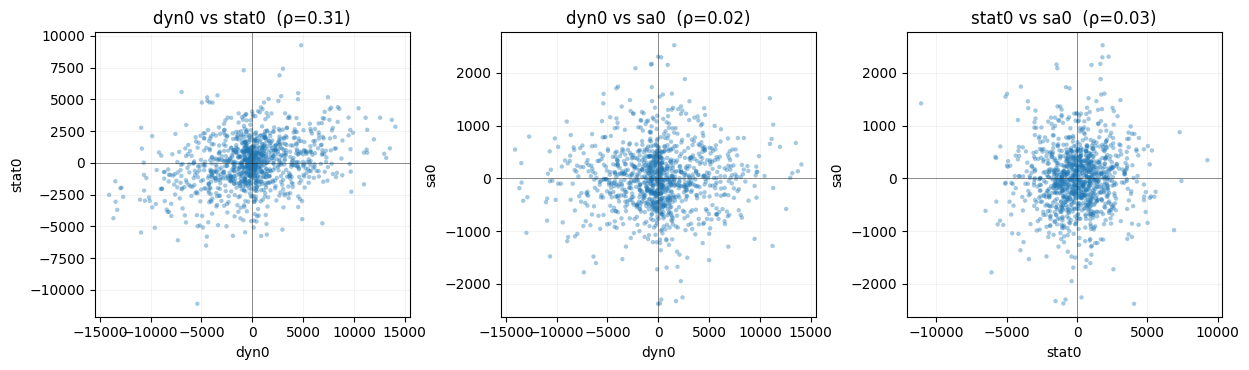

In [5]:
# Pairwise scatter plots of residuals
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math

R = np.asarray(resid, float)  # shape (T-1, d)
d = R.shape[1]
labels = names if (isinstance(names, (list, tuple)) and len(names)==d) else [f"f{j}" for j in range(d)]

pairs = list(combinations(range(d), 2))
cols = min(3, len(pairs))
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.8), squeeze=False)

for ax, (i, j) in zip(axes.ravel(), pairs):
    x, y = R[:, i], R[:, j]
    rho = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=10, alpha=0.4, edgecolors="none")
    ax.axhline(0, color="k", lw=0.5, alpha=0.6)
    ax.axvline(0, color="k", lw=0.5, alpha=0.6)
    ax.set_xlabel(labels[i]); ax.set_ylabel(labels[j])
    ax.set_title(f"{labels[i]} vs {labels[j]}  (ρ={rho:.2f})")
    ax.grid(alpha=0.15)

# hide any unused axes
for k in range(len(pairs), rows*cols):
    fig.delaxes(axes.ravel()[k])

plt.tight_layout()
plt.show()

## Simulation of Prices with Factors

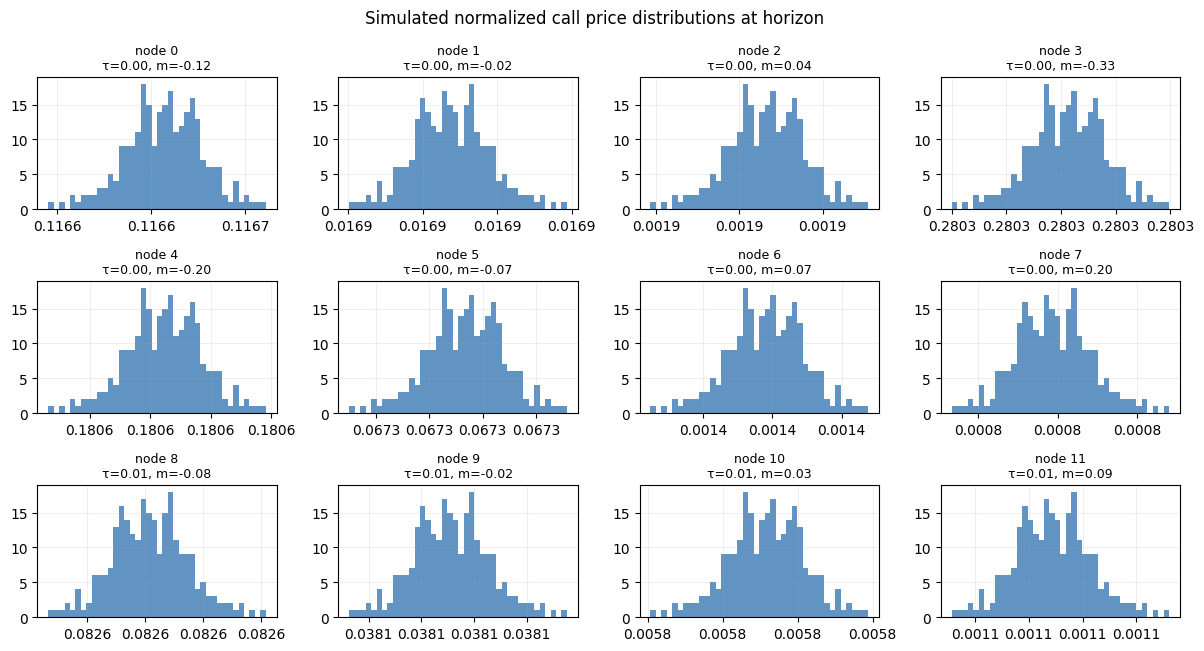

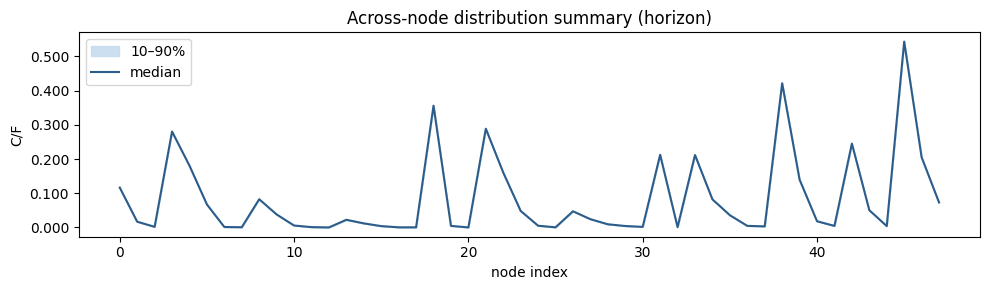

In [6]:
# Requires:
# - outs from decoding (Algo1Outputs, e.g. from decoding_aggre.ipynb)
# - model from neural_sde training (e.g. likelihood_training)
# Optional:
# - mu, sd returned by likelihood_training if standardisation was used

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

device = next(model.parameters()).device

# 1) Factor dimension and helper to split [dyn|stat|sa] blocks (order matches build_xi_training_data)
k_dyn  = outs.G_dyn.shape[0] if getattr(outs, "G_dyn", None) is not None and outs.G_dyn.size else 0
k_stat = outs.G_stat.shape[0] if getattr(outs, "G_stat", None) is not None and outs.G_stat.size else 0
k_sa   = outs.G_sa.shape[0]   if getattr(outs, "G_sa",   None) is not None and outs.G_sa.size   else 0
p = k_dyn + k_stat + k_sa
N = outs.G0.shape[0]  # number of nodes

def split_blocks(x):
    """x: (..., p) -> (xd, xs, xa)"""
    i = 0
    xd = x[..., i:i+k_dyn];  i += k_dyn
    xs = x[..., i:i+k_stat]; i += k_stat
    xa = x[..., i:i+k_sa] if k_sa>0 else x[..., :0]
    return xd, xs, xa

# 2) Build train factors (for x0) and dt (years)
X_tr, _, names = build_xi_training_data(outs)
x0_raw = X_tr[-1].astype(np.float64)  # last observed state as start

sec_per_year = 365.0*24*3600
tt_tr = pd.to_datetime(outs.C_train.index.values)
dt_tr = np.asarray((tt_tr[1:] - tt_tr[:-1]).total_seconds(), dtype=np.float64) / sec_per_year
dt = float(np.median(dt_tr)) if len(dt_tr) else (1.0/365/24/60)  # ~1 minute fallback

# 3) Prepare standardisation if available (depends on your likelihood_training return)
def to_model_space(x):
    if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
        mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
        sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
        return (x - mu_np.ravel()) / (sd_np.ravel() + 1e-9)
    return x

def from_model_space(x):
    if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
        mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
        sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
        return x * sd_np.ravel() + mu_np.ravel()
    return x

# 4) Euler–Maruyama simulation for factors under [`neural_sde.nets.NeuralSDE`](neural_sde/nets.py)
@torch.no_grad()
def simulate_factors(model, x0_raw, n_steps=60, n_paths=256, dt_years=dt, clamp_sig=1e-9):
    x0 = to_model_space(x0_raw.astype(np.float64))
    x  = torch.from_numpy(np.tile(x0, (n_paths, 1))).float().to(device)  # (B, p)
    out = [x.clone()]
    DT = torch.tensor(dt_years, dtype=torch.float32, device=device).view(1,1)
    for _ in range(n_steps):
        mu  = model.f(0.0, x)
        sig = model.g(0.0, x).clamp_min(clamp_sig)        # diagonal diffusion per-dim
        eps = torch.randn_like(x)
        x   = x + mu*DT + sig*torch.sqrt(DT)*eps
        out.append(x.clone())
    X_std = torch.stack(out, dim=1)  # (B, T+1, p)
    X_raw = from_model_space(X_std.cpu().numpy())
    return X_raw  # numpy (n_paths, n_steps+1, p)

# 5) Map factors -> normalized option prices at each lattice node
#    C = G0 + Xi_dyn·G_dyn + Xi_stat·G_stat + Xi_sa·G_sa  (see [`factors.decode.reconstruct_prices`](factors/decode.py))
def factors_to_prices(X):
    """
    X: (B, T+1, p) in raw Xi space
    Returns: C: (B, T+1, N) normalized prices per node
    """
    B, T1, _ = X.shape
    C = np.empty((B, T1, N), dtype=np.float64)
    G0 = outs.G0.astype(np.float64)
    Gd = outs.G_dyn.astype(np.float64) if k_dyn>0 else np.zeros((0, N))
    Gs = outs.G_stat.astype(np.float64) if k_stat>0 else np.zeros((0, N))
    Ga = outs.G_sa.astype(np.float64)   if k_sa>0   else np.zeros((0, N))
    for t in range(T1):
        xt = X[:, t, :]                    # (B, p)
        xd, xs, xa = split_blocks(xt)      # (B,k_*)
        C[:, t, :] = (G0[None, :]
                      + (xd @ Gd) if k_dyn>0 else 0.0
                      + (xs @ Gs) if k_stat>0 else 0.0
                      + (xa @ Ga) if k_sa>0   else 0.0)
    # Optional no‑arb clipping to [max(1-exp(m),0), 1]
    m = outs.nodes_sub[:, 1].astype(np.float64)
    lb = np.maximum(1.0 - np.exp(m), 0.0)
    C = np.clip(C, lb[None, None, :], 1.0)
    return C

# 6) Run simulation and get price distribution at horizon
n_paths = 256
n_steps = 60   # horizon steps (~60 minutes if dt is 1 minute)
X_sim = simulate_factors(model, x0_raw, n_steps=n_steps, n_paths=n_paths, dt_years=dt)
C_sim = factors_to_prices(X_sim)   # (B, T+1, N)

# Choose horizon snapshot (final time)
C_T = C_sim[:, -1, :]              # (B, N)

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def tidy_x_axis(ax, data):
    # turn off offset/scientific notation
    ax.ticklabel_format(axis="x", style="plain", useOffset=False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    # choose a readable fixed-decimal formatter based on range
    rng = float(np.ptp(data))
    if rng < 0.02:
        fmt = FormatStrFormatter('%.4f')
    elif rng < 0.2:
        fmt = FormatStrFormatter('%.3f')
    else:
        fmt = FormatStrFormatter('%.2f')
    ax.xaxis.set_major_formatter(fmt)

# 7) Visualise: histograms for first 12 nodes and a violin summary
n_show = min(12, C_T.shape[1])
fig, axes = plt.subplots(int(np.ceil(n_show/4)), 4, figsize=(12, 2.2*np.ceil(n_show/4)), squeeze=False)
axes = axes.ravel()
for j in range(n_show):
    ax = axes[j]
    ax.hist(C_T[:, j], bins=40, alpha=0.8, color="#3a78b4")
    τ, m = outs.nodes_sub[j, 0], outs.nodes_sub[j, 1]
    tidy_x_axis(ax, C_T[:, j])
    ax.set_title(f"node {j}\nτ={τ:.2f}, m={m:.2f}", fontsize=9)
    ax.grid(alpha=0.2)
for k in range(n_show, len(axes)):
    fig.delaxes(axes[k])
fig.suptitle("Simulated normalized call price distributions at horizon", y=0.98)
plt.tight_layout(); plt.show()

# Violin summary: also remove offset on y (prices)
plt.figure(figsize=(10,3))
q_lo, q_md, q_hi = np.quantile(C_T, [0.1, 0.5, 0.9], axis=0)
plt.fill_between(np.arange(N), q_lo, q_hi, color="#c7dcef", alpha=0.9, label="10–90%")
plt.plot(q_md, color="#2c5d8a", lw=1.5, label="median")
ax = plt.gca()
ax.ticklabel_format(axis="y", style="plain", useOffset=False)
ax.get_yaxis().get_offset_text().set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title("Across-node distribution summary (horizon)"); plt.xlabel("node index"); plt.ylabel("C/F")
plt.legend(); plt.tight_layout(); plt.show()


                 portfolio  alpha           VaR          CVaR      mean_PnL  \
0       1x2x1 Call Fly ~1d   0.95  4.340708e-06  5.504352e-06 -3.566157e-07   
1             Long ATM ~1d   0.95  3.679888e-07  5.047363e-07  4.010726e-08   
2      Short OTM +0.10 ~1d   0.95  3.216392e-07  4.078633e-07 -2.642463e-08   
3  Calendar ATM: +3d / -1d   0.95 -0.000000e+00 -0.000000e+00  0.000000e+00   
4       1x2x1 Call Fly ~1d   0.99  6.162656e-06  6.855497e-06 -3.566157e-07   
5             Long ATM ~1d   0.99  5.693369e-07  6.244880e-07  4.010726e-08   
6      Short OTM +0.10 ~1d   0.99  4.566425e-07  5.079808e-07 -2.642463e-08   
7  Calendar ATM: +3d / -1d   0.99 -0.000000e+00 -0.000000e+00  0.000000e+00   

        std_PnL  notional_abs_sum  
0  2.353703e-06               4.0  
1  2.647123e-07               1.0  
2  1.744055e-07               1.0  
3  0.000000e+00               0.0  
4  2.353703e-06               4.0  
5  2.647123e-07               1.0  
6  1.744055e-07               1.0  


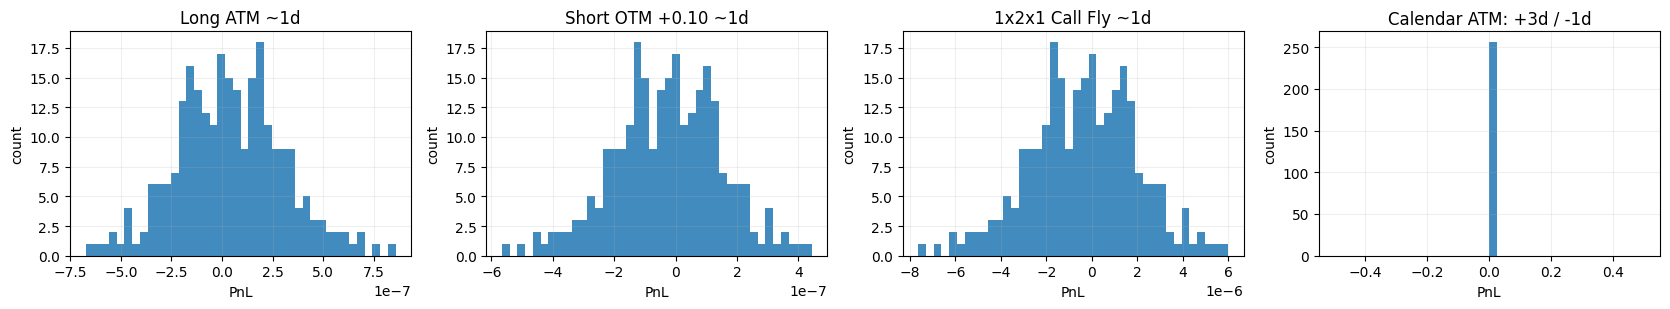

In [7]:
def portfolio_var_from_C(C_sim, q, F0=1.0, multipliers=None, alpha=0.99):
    """
    C_sim: (B, T+1, N) normalized prices C/F
    q:     (N,) portfolio holdings per node
    F0:    scalar forward at t0 to convert to dollars (use 1.0 to stay normalized)
    multipliers: (N,) contract multipliers (default 1.0)
    """
    C_sim = np.asarray(C_sim)
    q = np.asarray(q).reshape(-1)
    B, T1, N = C_sim.shape
    assert q.shape[0] == N, "q must match number of nodes"

    w = np.ones(N) if multipliers is None else np.asarray(multipliers).reshape(-1)
    notional = q * F0 * w  # (N,)

    V0 = C_sim[:, 0, :] @ notional      # (B,)
    VT = C_sim[:, -1, :] @ notional     # (B,)
    dV = VT - V0                        # (B,)

    qtile = np.quantile(dV, 1 - alpha)
    var   = -qtile
    cvar  = -dV[dV <= qtile].mean()
    return var, cvar, dV


# ------------------------------------------------------------
# Helpers: map specs -> q vectors
# ------------------------------------------------------------
def nearest_node_index(tau, m, nodes):
    """
    nodes: array of shape (N,2) with columns [tau, m]
    returns index j of the nearest node by Euclidean distance in (tau, m).
    """
    diffs = nodes - np.array([tau, m])[None, :]
    j = np.argmin(np.sum(diffs*diffs, axis=1))
    return int(j)

def make_q_from_spec(spec, nodes):
    """
    Build q vector (N,) from a portfolio spec.
    spec can be:
      - dict {int_node_index: qty, ...}
      - list of (tau, m, qty) tuples (mapped to nearest node)
    """
    N = nodes.shape[0]
    q = np.zeros(N, dtype=float)
    if isinstance(spec, dict):
        for j, qty in spec.items():
            q[int(j)] += float(qty)
        return q

    # assume iterable of (tau, m, qty)
    for tau, m, qty in spec:
        j = nearest_node_index(float(tau), float(m), nodes)
        q[j] += float(qty)
    return q

# ------------------------------------------------------------
# Bulk evaluation
# ------------------------------------------------------------
def evaluate_var_for_portfolios(C_sim, portfolios, nodes, F0=1.0, multipliers=None, alphas=(0.99,)):
    """
    portfolios: dict name -> spec (dict of {node_index: qty} OR list of (tau, m, qty))
    returns: (summary_df, details) where:
      - summary_df: tidy table with VaR/CVaR per portfolio & alpha
      - details: dict name -> dict { 'q': q, 'PnL': dV }
    """
    results = []
    details = {}
    for name, spec in portfolios.items():
        q = make_q_from_spec(spec, nodes)
        # compute once, then grab for all alphas
        _, _, dV = portfolio_var_from_C(C_sim, q, F0=F0, multipliers=multipliers, alpha=alphas[0])
        details[name] = {'q': q, 'PnL': dV}

        for a in alphas:
            var_a, cvar_a, _ = portfolio_var_from_C(C_sim, q, F0=F0, multipliers=multipliers, alpha=a)
            results.append({
                'portfolio': name,
                'alpha': a,
                'VaR': var_a,
                'CVaR': cvar_a,
                'mean_PnL': float(np.mean(dV)),
                'std_PnL': float(np.std(dV, ddof=1)),
                'notional_abs_sum': float(np.sum(np.abs(q)))  # in normalized units unless F0/multipliers used
            })

    summary = pd.DataFrame(results).sort_values(['alpha','VaR'], ascending=[True, False]).reset_index(drop=True)
    return summary, details

# ------------------------------------------------------------
# Example portfolio set
# nodes_2d should be your (tau, m) for each lattice node.
# Prefer outs.nodes_sub if present, else outs.nodes.
# ------------------------------------------------------------
nodes_2d = getattr(outs, 'nodes_sub', getattr(outs, 'nodes_sub'))
assert nodes_2d.shape[1] == 2, "nodes must have shape (N,2) with [tau, m]"

# Build a few example portfolios (edit to your needs):
tau_near_1d = 1.0/365.0
tau_near_3d = 3.0/365.0
m_atm       = 0.0
m_otm_up    = +0.10
m_otm_dn    = -0.10

portfolios = {
    # 1) Long single near-ATM call (by (tau,m))
    "Long ATM ~1d": [
        (tau_near_1d, m_atm, +1.0)
    ],

    # 2) Short OTM ~1d
    "Short OTM +0.10 ~1d": [
        (tau_near_1d, m_otm_up, -1.0)
    ],

    # 3) Call butterfly around ATM at ~1d: +1 at m=-0.10, -2 at m=0, +1 at m=+0.10
    "1x2x1 Call Fly ~1d": [
        (tau_near_1d, m_otm_dn, +1.0),
        (tau_near_1d, m_atm,    -2.0),
        (tau_near_1d, m_otm_up, +1.0)
    ],

    # 4) ATM calendar: long near 3d, short near 1d
    "Calendar ATM: +3d / -1d": [
        (tau_near_3d, m_atm, +1.0),
        (tau_near_1d, m_atm, -1.0)
    ],
}


# ------------------------------------------------------------
# Run VaR evaluation
# ------------------------------------------------------------
# Choose your conversion to dollars if you want absolute VaR:
# - F0: current forward/spot at t0 (e.g., BTCUSD price)
# - multipliers: contract sizes per node (vector length N) if needed
F0 = 1.0
multipliers = None
alphas = (0.95, 0.99)

summary_df, details = evaluate_var_for_portfolios(
    C_sim=C_sim,
    portfolios=portfolios,
    nodes=nodes_2d,
    F0=F0,
    multipliers=multipliers,
    alphas=alphas
)

print(summary_df)

# ------------------------------------------------------------
# (Optional) quick P&L histogram per portfolio
# ------------------------------------------------------------
import matplotlib.pyplot as plt
cols = len(portfolios)
fig, axes = plt.subplots(1, cols, figsize=(4.2*cols, 3.2), squeeze=False)
for ax, (name, info) in zip(axes.ravel(), details.items()):
    dV = info['PnL']
    ax.hist(dV, bins=40, alpha=0.85)
    ax.set_title(name)
    ax.set_xlabel("PnL")
    ax.set_ylabel("count")
    ax.grid(alpha=0.2)
plt.tight_layout(); plt.show()


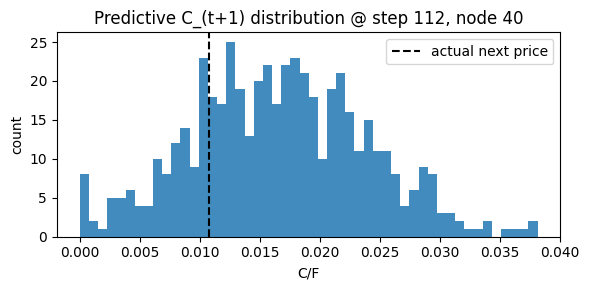

PIT mean (should be ~0.5 if calibrated): 0.21678531804733728


In [8]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device

# ---------------------------
# 1) Factors & dt (TEST SET)
# ---------------------------
# Build test factors in the SAME order as training
_, X_te, names = build_xi_training_data(outs)  # shape (T_test, p)
X_te = X_te.astype(np.float64)
T_test, p = X_te.shape

# Test dt in years from test index
sec_per_year = 1
tt_te = pd.to_datetime(outs.C_test.index.values)
dt_te = np.asarray((tt_te[1:] - tt_te[:-1]).astype('timedelta64[s]'), dtype=np.int64) / sec_per_year
assert len(dt_te) == T_test 

# ---------------------------
# 2) Standardisation hooks
# ---------------------------
def to_model_space(x):
    # if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
    #     mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
    #     sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
    #     return (x - mu_np.ravel()) / (sd_np.ravel() + 1e-9)
    return x

def from_model_space(x):
    # if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
    #     mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
    #     sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
    #     return x * sd_np.ravel() + mu_np.ravel()
    return x

# ---------------------------
# 3) Factors → prices (batch)
# ---------------------------
k_dyn  = outs.G_dyn.shape[0] if getattr(outs, "G_dyn", None) is not None and outs.G_dyn.size else 0
k_stat = outs.G_stat.shape[0] if getattr(outs, "G_stat", None) is not None and outs.G_stat.size else 0
k_sa   = outs.G_sa.shape[0]   if getattr(outs, "G_sa",   None) is not None and outs.G_sa.size   else 0
N = outs.G0.shape[0]

G0 = outs.G0.astype(np.float64)
Gd = outs.G_dyn.astype(np.float64) if k_dyn  > 0 else np.zeros((0, N))
Gs = outs.G_stat.astype(np.float64) if k_stat > 0 else np.zeros((0, N))
Ga = outs.G_sa.astype(np.float64)   if k_sa   > 0 else np.zeros((0, N))

def split_blocks(x):
    i = 0
    xd = x[..., i:i+k_dyn];  i += k_dyn
    xs = x[..., i:i+k_stat]; i += k_stat
    xa = x[..., i:i+k_sa] if k_sa>0 else x[..., :0]
    return xd, xs, xa

def x_to_prices_batch(X_batch):
    """
    X_batch: (B, p) raw Xi → returns (B, N) normalized prices
    """
    xd, xs, xa = split_blocks(X_batch)
    term = np.broadcast_to(G0, (X_batch.shape[0], N)).copy()
    if k_dyn  > 0: term += xd @ Gd
    if k_stat > 0: term += xs @ Gs
    if k_sa   > 0: term += xa @ Ga
    # No-arb clipping
    m = outs.nodes_sub[:, 1].astype(np.float64) if hasattr(outs, 'nodes_sub') else outs.nodes[:,1].astype(np.float64)
    lb = np.maximum(1.0 - np.exp(m), 0.0)
    return np.clip(term, lb[None, :], 1.0)

# ---------------------------
# 4) One-step predictive draw
# ---------------------------
@torch.no_grad()
def one_step_draw_C(model, x0_raw, dt_years, n_paths=512, clamp_sig=1e-9):
    """
    x0_raw: (p,) raw Xi at time t
    dt_years: scalar
    returns: C_{t+1} draws as (n_paths, N)
    """
    x0 = to_model_space(x0_raw.astype(np.float64))
    x  = torch.from_numpy(np.tile(x0, (n_paths, 1))).float().to(device)  # (B, p)
    DT = torch.tensor(dt_years, dtype=torch.float32, device=device).view(1,1)

    mu  = model.f(0.0, x)
    sig = model.g(0.0, x).clamp_min(clamp_sig)   # diagonal diffusion per dim
    eps = torch.randn_like(x)
    x1  = x + mu*DT + sig*torch.sqrt(DT)*eps     # Euler one-step

    X1_raw = from_model_space(x1.detach().cpu().numpy())
    C1     = x_to_prices_batch(X1_raw)           # (n_paths, N)
    return C1

# ---------------------------
# 5) Roll through test set:
#    node overlay and histogram
# ---------------------------
node_idx   = 40              # <- choose the lattice node to evaluate/plot
alpha_band = (0.05, 0.95)   # predictive band

C_actual = outs.C_test.values.astype(np.float64)  # (T_test, N) normalized
assert C_actual.shape[0] == T_test + 1

n_paths = 512
q_lo_series, q_md_series, q_hi_series = [], [], []
actual_series = []
time_index = tt_te[1:]  # we predict t+1

# collect also PIT values if you want calibration later
pit_vals = []

for t in range(T_test - 1):
    C1_draws = one_step_draw_C(model, X_te[t], dt_te[t], n_paths=n_paths)  # (B, N)
    # predictive stats for chosen node
    draws_node = C1_draws[:, node_idx]
    q_lo, q_md, q_hi = np.quantile(draws_node, [alpha_band[0], 0.5, alpha_band[1]])
    q_lo_series.append(q_lo); q_md_series.append(q_md); q_hi_series.append(q_hi)
    actual = C_actual[t+1, node_idx]
    actual_series.append(actual)
    # PIT
    pit_vals.append((draws_node <= actual).mean())

q_lo_series = np.array(q_lo_series)
q_md_series = np.array(q_md_series)
q_hi_series = np.array(q_hi_series)
actual_series = np.array(actual_series)
pit_vals = np.array(pit_vals)

# ---------------------------
# 6) Plot: predictive band vs actual
# ---------------------------
steps = np.arange(q_lo_series.size)             # align x with computed series
# optional: keep a matching time index if you want to label dates later
time_index_plot = tt_te[1:][:q_lo_series.size]  # from [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py)

plt.figure(figsize=(11,3.6))
plt.fill_between(steps, q_lo_series, q_hi_series, alpha=0.25,
                 label=f'{int(100*(alpha_band[1]-alpha_band[0]))}% pred. band')
plt.plot(steps, q_md_series, lw=1.5, label='predictive median')
plt.plot(steps, actual_series, lw=1.2, label='actual', alpha=0.9)
plt.title(f"One-step predictive band vs actual  (node {node_idx})")
plt.xlabel("test step"); plt.ylabel("C/F (normalized)")
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

# ---------------------------
# 7) One example step histogram with actual overlay
# ---------------------------
t_example = steps.size // 3                     # pick a valid step
C1_draws = one_step_draw_C(model, X_te[t_example], dt_te[t_example], n_paths=n_paths)
draws_node = C1_draws[:, node_idx]
plt.figure(figsize=(6,3))
plt.hist(draws_node, bins=50, alpha=0.85)
plt.axvline(C_actual[t_example+1, node_idx], color='k', ls='--', lw=1.5, label='actual next price')
plt.title(f"Predictive C_(t+1) distribution @ step {t_example}, node {node_idx}")
plt.xlabel("C/F"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) PIT quick check
print("PIT mean (should be ~0.5 if calibrated):", pit_vals.mean())


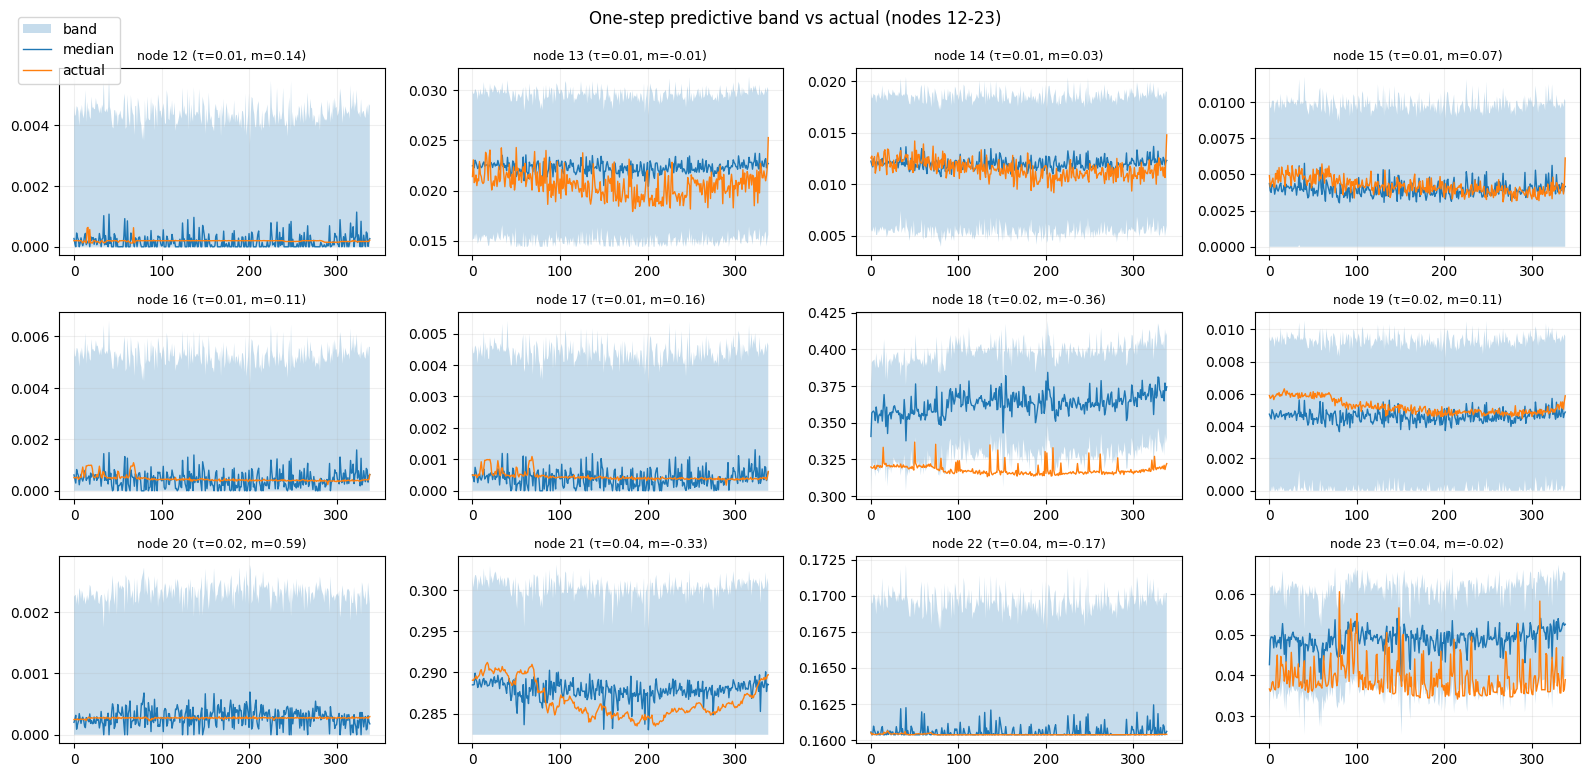

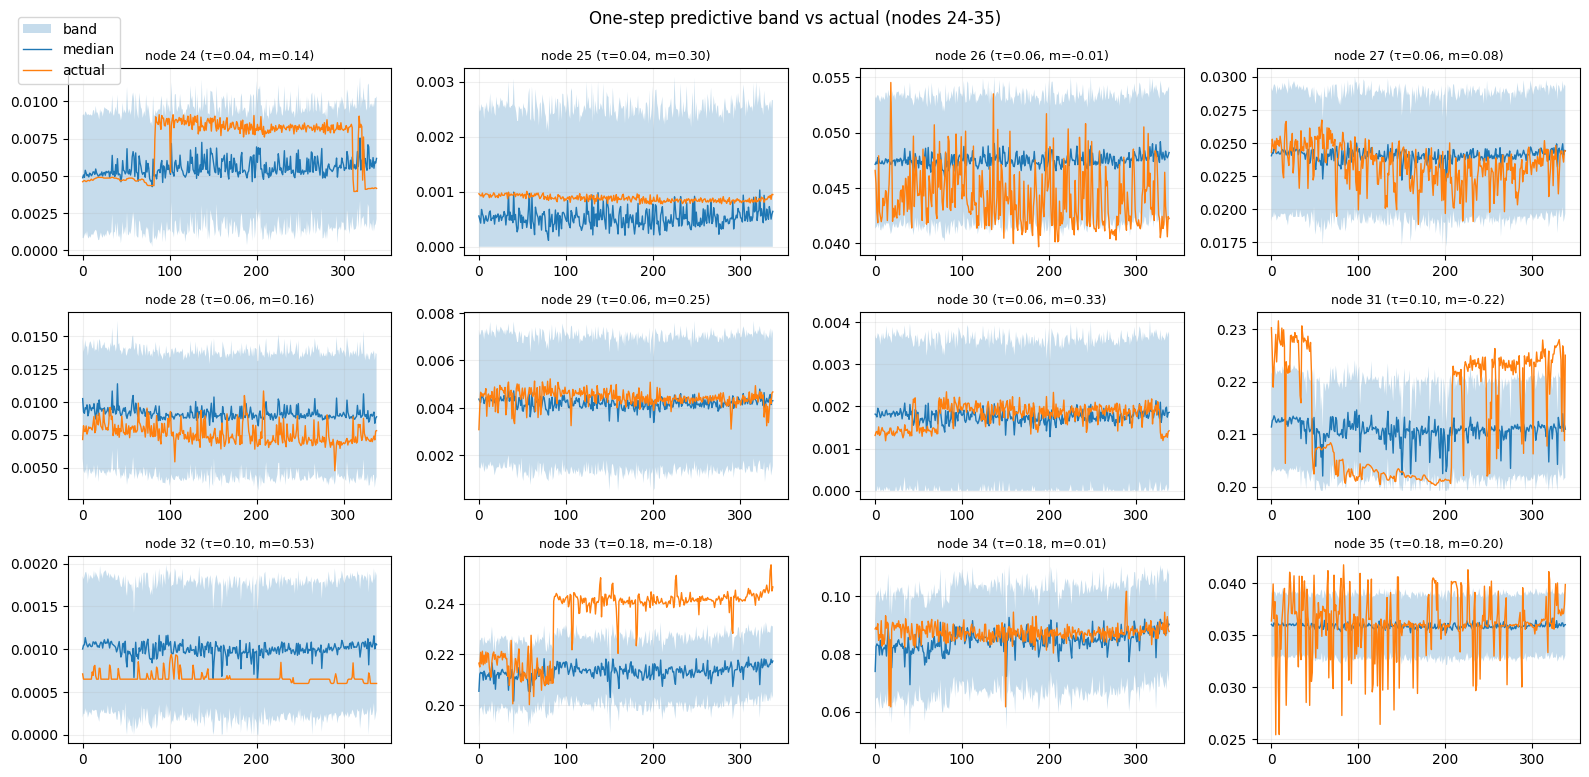

Mean coverage across nodes: 0.8461160275319567
Mean PIT mean across nodes: 0.46418814720071294


In [9]:
# ---------- align once ----------
sec_per_year = 1  
C_test = outs.C_test.values.astype(np.float64)           # (T_c, N)
idx_c  = pd.to_datetime(outs.C_test.index.values)
dt_years = np.asarray((idx_c[1:] - idx_c[:-1]).astype('timedelta64[s]'),
                      dtype=np.int64) / sec_per_year     # (T_c-1,)

_, X_te, _ = build_xi_training_data(outs)                # (T_x, p)
X_te = X_te.astype(np.float64)

steps = min(len(dt_years), X_te.shape[0], C_test.shape[0]-1)
N = outs.G0.shape[0]

# ---------- compute bands for ALL nodes ----------
def one_step_bands_all_nodes(model, X_te, dt_years, C_next, n_paths=1024, band=(0.06,0.94)):
    T = min(len(dt_years), X_te.shape[0], C_next.shape[0])
    q_lo = np.empty((T, N)); q_md = np.empty((T, N)); q_hi = np.empty((T, N))
    pits = np.empty((T, N))
    for t in range(T):
        C1_draws = one_step_draw_C(model, X_te[t], dt_years[t], n_paths=n_paths)  # (B, N)
        qs = np.quantile(C1_draws, [band[0], 0.5, band[1]], axis=0)               # (3, N)
        q_lo[t], q_md[t], q_hi[t] = qs[0], qs[1], qs[2]
        pits[t] = (C1_draws <= C_next[t]).mean(axis=0)
    return q_lo, q_md, q_hi, pits

q_lo, q_md, q_hi, pits = one_step_bands_all_nodes(
    model,
    X_te[:steps],
    dt_years[:steps],
    C_test[1:steps+1],          # actual at t+1
    n_paths=1024,
    band=(0.055, 0.945)         # ~89% like your plot
)

# ---------- small-multiple plots over nodes ----------
nodes_2d = getattr(outs, 'nodes_sub', getattr(outs, 'nodes_sub'))  # (N,2) [tau, m]

def plot_bands_grid(q_lo, q_md, q_hi, actual, nodes_2d, cols=4, rows=3):
    T, N = q_lo.shape
    idx = np.arange(T)
    per_fig = cols*rows
    for start in range(0, N, per_fig):
        end = min(start+per_fig, N)
        m = end - start
        r = math.ceil(m/cols)
        fig, axes = plt.subplots(r, cols, figsize=(cols*4.0, r*2.6), squeeze=False)
        axes = axes.ravel()
        for k, j in enumerate(range(start, end)):
            ax = axes[k]
            ax.fill_between(idx, q_lo[:, j], q_hi[:, j], alpha=0.25, label='band' if k==0 else None)
            ax.plot(idx, q_md[:, j], lw=1.0, label='median' if k==0 else None)
            ax.plot(idx, actual[:, j], lw=1.0, label='actual' if k==0 else None)
            tau, moneyness = nodes_2d[j, 0], nodes_2d[j, 1]
            ax.set_title(f"node {j} (τ={tau:.2f}, m={moneyness:.2f})", fontsize=9)
            ax.grid(alpha=0.2)
        # remove empty axes
        for k in range(m, len(axes)):
            fig.delaxes(axes[k])
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))
        fig.suptitle(f"One-step predictive band vs actual (nodes {start}-{end-1})", y=0.99)
        plt.tight_layout(); plt.show()

plot_bands_grid(q_lo, q_md, q_hi, C_test[1:steps+1], nodes_2d, cols=4, rows=3)

# ---------- optional: per-node calibration summary ----------
coverage = ((C_test[1:steps+1] >= q_lo) & (C_test[1:steps+1] <= q_hi)).mean(axis=0)   # (N,)
pit_mean = pits.mean(axis=0)                                                          # (N,)
print("Mean coverage across nodes:", float(coverage.mean()))
print("Mean PIT mean across nodes:", float(pit_mean.mean()))

In [12]:
# compute on TEST set, same X_te and dt_te you use in bands
# ...existing code...
import torch, numpy as np

device = next(model.parameters()).device
Y0 = torch.from_numpy(X_te[:-1]).float().to(device)
Y1 = torch.from_numpy(X_te[1:]).float().to(device)
DT = torch.from_numpy(dt_te[:-1].copy()).float().to(device).unsqueeze(1).clamp_min(1e-12)

with torch.no_grad():
    mu  = model.f(0.0, Y0)                     # drift
    sig = model.g(0.0, Y0).clamp_min(1e-9)     # diffusion

# realized vs model one-step increment (factor space)
dx_real = (Y1 - Y0).cpu().numpy()
dx_pred = (mu*DT).cpu().numpy()

drift_bias = dx_pred.mean(0) - dx_real.mean(0)
print("Mean realized Δx per factor:", np.round(dx_real.mean(0), 6))
print("Mean model μ·Δt per factor:", np.round(dx_pred.mean(0), 6))
print("Drift bias (μΔt - Δx):     ", np.round(drift_bias, 6))

Mean realized Δx per factor: [ 9.6e-05 -6.1e-05 -7.0e-06]
Mean model μ·Δt per factor: [0. 0. 0.]
Drift bias (μΔt - Δx):      [-9.6e-05  6.1e-05  7.0e-06]


In [12]:
# ...existing code...
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_one_step_dists_all_nodes(model, X_te, dt_te, C_test, t, n_paths=512, bins=40, cols=4):
    """
    Small-multiple histograms of predictive C_(t+1) per node with actual overlay.
    - X_te: (T_test, p) factors
    - dt_te: (T_test,) time deltas (same unit used in training/inference)
    - C_test: (T_test+1, N) normalized prices from outs (see [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py))
    - t: int step index where we predict t+1
    """
    assert 0 <= t < min(len(dt_te), X_te.shape[0], C_test.shape[0]-1)
    draws = one_step_draw_C(model, X_te[t], dt_te[t], n_paths=n_paths)   # (B, N)
    actual_next = C_test[t+1]                                           # (N,)
    N = draws.shape[1]
    nodes_2d = getattr(outs, 'nodes_sub', getattr(outs, 'nodes_sub'))

    rows = math.ceil(N / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.8, rows*2.8), squeeze=False)
    axes = axes.ravel()

    for j in range(N):
        ax = axes[j]
        dj = draws[:, j]
        ax.hist(dj, bins=bins, alpha=0.85, color="#3a78b4")
        ax.axvline(actual_next[j], color="k", ls="--", lw=1.2, label="actual next")
        # optional: show PIT and median
        pit = float((dj <= actual_next[j]).mean())
        med = float(np.median(dj))
        τ, m = nodes_2d[j, 0], nodes_2d[j, 1]
        ax.set_title(f"node {j}  τ={τ:.2f}, m={m:.2f}\nPIT={pit:.2f}, med={med:.3f}", fontsize=8)
        ax.grid(alpha=0.2)
        if j % cols == 0: ax.set_ylabel("count")
        ax.set_xlabel("C/F")

    for k in range(N, len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle(f"Predictive C_(t+1) distributions @ step {t}", y=0.99)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    plt.tight_layout(); plt.show()

# Example usage (pick a valid test step index)
t_example = 220
C_test_np = outs.C_test.values.astype(np.float64)  # [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py)
plot_one_step_dists_all_nodes(model, X_te, dt_te, C_test_np, t=t_example, n_paths=512, bins=50, cols=4)
# ...existing code...

In [13]:
# Reconstruct C_t from X_t and compare to actual C_t (same time, not t+1)
C_now_pred = x_to_prices_batch(X_te)                  # shape (T_test, N)
C_now_act  = outs.C_test.values.astype(np.float64)[:-1]  # drop last to match length
r2 = np.corrcoef(C_now_pred.ravel(), C_now_act.ravel())[0,1]**2
mae = np.mean(np.abs(C_now_pred - C_now_act))
print(f"Nowcast R^2 ~ {r2:.4f}, MAE ~ {mae:.6g}")
# Compare per-node mean level from nowcasts vs actuals
lvl_diff = C_now_pred.mean(0) - C_now_act.mean(0)
print("Max abs node-level mean diff:", float(np.max(np.abs(lvl_diff))))


Nowcast R^2 ~ 0.9956, MAE ~ 0.00394858
Max abs node-level mean diff: 0.03019164734414806


In [14]:
import numpy as np
import torch
from sklearn.linear_model import Ridge

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Training data: Xi and normalized calls c = C/F
X_tr, X_te, xi_names = build_xi_training_data(outs)          # shapes: (T,k), (T*,k)
C_tr_full = outs.C_train.values.astype(np.float64)           # (T,N)
L = min(len(C_tr_full)-1, X_tr.shape[0])                     # align to Xi length

C_tr = C_tr_full[:L]                 # (T,N)
F_tr = getattr(outs, "F_train", None)
if F_tr is not None:
    F_tr = np.asarray(F_tr.values, dtype=np.float64)          # (T,)
    c_tr = C_tr / F_tr[:, None]
else:
    # If you don't track F, work purely in normalized units provided in outs.C_train already
    # (i.e., assume outs.C_* are normalized). Adjust to your pipeline.
    c_tr = C_tr

# 2) Fit linear decoder: c ≈ μ + B xi
reg = Ridge(alpha=1e-6, fit_intercept=True)
reg.fit(X_tr, c_tr)
B_np = reg.coef_.astype(np.float64)      # (N,k)
mu_np = reg.intercept_.astype(np.float64)# (N,)

# Torch tensors
B = torch.tensor(B_np, dtype=torch.float32, device=device)  # (N,k)
mu = torch.tensor(mu_np, dtype=torch.float32, device=device) # (N,)

def decoder_linear(xi_t: torch.Tensor) -> torch.Tensor:
    """xi_t: (k,) -> c_t: (N,) normalized prices"""
    return mu + (B @ xi_t)


from typing import List, Tuple

def vector_q(N: int, positions: List[Tuple[int, float]], device="cpu"):
    q = torch.zeros(N, dtype=torch.float32, device=device)
    for idx, qty in positions:
        q[idx] += float(qty)
    return q

def build_sensitivity_hedge(B: torch.Tensor,
                            portfolio_positions: List[Tuple[int, float]],
                            hedge_universe: List[int],
                            l2_reg: float = 1e-6):
    """
    B: (N,k) decoder loadings => sensitivities w.r.t Xi
    portfolio_positions: list of (node_idx, qty)
    hedge_universe: list of node indices you can trade as hedges

    Returns hedge weights aligned to hedge_universe, and residual exposure.
    """
    N, k = B.shape
    q = vector_q(N, portfolio_positions, device=B.device)     # (N,)
    g = B.T @ q                                               # (k,)
    BH = B[hedge_universe, :]                                 # (|H|, k)
    A = BH.T                                                  # (k, |H|)

    # Solve (A^T A + λI) h = -A^T g
    ATA = A.T @ A + l2_reg*torch.eye(A.shape[1], device=B.device)
    ATg = A.T @ g
    h = torch.linalg.solve(ATA, -ATg)                         # (|H|,)

    residual = A @ h + g                                      # (k,)
    return h.detach(), residual.detach()


# Example portfolio: long 10 at node i0, short 3 at node i1
portfolio = [(1, 10.0), (26, -3.0)]
# Hedge on a small set (e.g., 3–10 near-ATM nodes you actually can trade)
hedge_universe = [9, 10, 14]

h, res = build_sensitivity_hedge(B, portfolio, hedge_universe, l2_reg=1e-5)
print("Hedge weights (aligned to hedge_universe):", h.cpu().numpy())
print("Residual factor exposure (should be small):", res.cpu().numpy())

def price_vector_linear(mu: torch.Tensor, B: torch.Tensor, xi_t: torch.Tensor, F_t: float = None):
    c = mu + B @ xi_t   # normalized prices (N,)
    return c if F_t is None else c * F_t

def run_simple_backtest(mu, B, X_test_np, F_test_np, portfolio, hedge_universe, rebalance_every=1, l2_reg=1e-6):
    X_te = torch.tensor(X_test_np, dtype=torch.float32, device=B.device)   # (T*,k)
    T = X_te.shape[0]
    hedge = [(i, 0.0) for i in hedge_universe]

    records = []
    for t in range(T-1):
        xi_t, xi_tp1 = X_te[t], X_te[t+1]
        F_t  = None if F_test_np is None else float(F_test_np[t])
        F_tp1= None if F_test_np is None else float(F_test_np[t+1])

        p_t   = price_vector_linear(mu, B, xi_t,   F_t)
        p_tp1 = price_vector_linear(mu, B, xi_tp1, F_tp1)

        if (t % rebalance_every) == 0:
            # Recompute sensitivity hedge using current positions (book + hedge)
            h, _ = build_sensitivity_hedge(B, portfolio + hedge, hedge_universe, l2_reg)
            hedge = list(zip(hedge_universe, h.cpu().numpy().tolist()))

        def value(p, pos): return sum(q * p[idx].item() for idx, q in pos)
        dV_book  = value(p_tp1, portfolio) - value(p_t, portfolio)
        dV_hedge = value(p_tp1, hedge)     - value(p_t, hedge)
        records.append({"t": t, "dV_book": dV_book, "dV_hedge": dV_hedge, "dV_net": dV_book + dV_hedge})
    return records




Hedge weights (aligned to hedge_universe): [-2.1822243 -2.79881   13.949217 ]
Residual factor exposure (should be small): [-0.03205272 -0.00954083 -0.00057178]


In [46]:
import numpy as np
import torch
from math import log, sqrt, exp
from typing import List, Tuple, Optional, Dict

# -----------------------------
# (A) Black–Scholes utilities
# -----------------------------
from math import erf

def _nd(x):
    # standard normal pdf
    return (1.0/np.sqrt(2*np.pi))*np.exp(-0.5*x*x)

def _Nc(x):
    # standard normal cdf
    return 0.5*(1.0 + erf(x/np.sqrt(2.0)))

def _bs_norm_call_from_m_tau(m: float, tau: float, vol: float) -> float:
    """
    Normalized BS call price c = C/F when F is the forward (r=q=0),
    strike ratio m = K/F, and tau is time to expiry (in years).
    """
    if tau <= 0.0 or vol <= 1e-12:
        return max(1.0 - m, 0.0)
    v = vol * np.sqrt(tau)
    if v <= 1e-12:
        return max(1.0 - m, 0.0)
    ln_1_over_m = -np.log(m)
    d1 = (ln_1_over_m + 0.5*v*v)/v
    d2 = d1 - v
    return _Nc(d1) - m*_Nc(d2)

def _implied_vol_from_c_m_tau(c: float, m: float, tau: float, tol: float=1e-8, max_iter: int=80) -> float:
    """
    Solve for BS vol from normalized price c and (m,tau) using a robust bisection.
    Returns np.nan if it cannot bracket sensibly.
    """
    if tau <= 0.0:
        # expiry: price is intrinsic -> vol undefined; return ~0
        return 0.0
    # Price bounds as vol->0 and vol->infty
    c_low = max(1.0 - m, 0.0)  # vol -> 0
    c_high = 1.0               # vol -> +inf (limit of N(d1) - m N(d2) is 1)
    # Clamp c into feasible interval
    c_clamped = min(max(c, c_low), c_high - 1e-12)
    if abs(c_clamped - c) > 1e-10:
        c = c_clamped
    # Quick exits
    if abs(c - c_low) < 1e-12: return 1e-10
    if c >= 1.0 - 1e-12:       return 5.0

    lo, hi = 1e-6, 5.0
    f_lo = _bs_norm_call_from_m_tau(m, tau, lo) - c
    f_hi = _bs_norm_call_from_m_tau(m, tau, hi) - c
    # Ensure monotone bracket
    if f_lo > 0.0: 
        # shift bracket down
        for _ in range(10):
            hi = lo; f_hi = f_lo
            lo *= 0.5
            f_lo = _bs_norm_call_from_m_tau(m, tau, lo) - c
            if f_lo <= 0.0: break
    if f_hi < 0.0:
        # shift bracket up
        for _ in range(10):
            lo = hi; f_lo = f_hi
            hi *= 2.0
            if hi > 50.0: break
            f_hi = _bs_norm_call_from_m_tau(m, tau, hi) - c
            if f_hi >= 0.0: break

    if not (f_lo <= 0.0 <= f_hi):
        # Failed to bracket; return a safe guess
        return np.nan

    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        f_mid = _bs_norm_call_from_m_tau(m, tau, mid) - c
        if abs(f_mid) < tol: 
            return mid
        if f_mid > 0.0:
            hi = mid
        else:
            lo = mid
        if (hi - lo) < 1e-8:
            return 0.5*(lo+hi)
    return 0.5*(lo+hi)

def _bs_forward_delta_from_m_tau_vol(m: float, tau: float, vol: float) -> float:
    """
    Forward delta: ∂C/∂F = N(d1) when pricing under forward with discount=1.
    (This is the delta you’d hedge with the underlying F or spot if r≈q≈0.)
    """
    if tau <= 0.0 or vol <= 1e-12:
        return 1.0 if (1.0 > m) else (0.0 if (1.0 < m) else 0.5)
    v = vol * np.sqrt(tau)
    d1 = (-np.log(m) + 0.5*v*v)/v
    return _Nc(d1)

# -----------------------------
# (B) Delta hedge backtest
# -----------------------------
def _compute_delta_vector_from_decoder_prices(
    mu: torch.Tensor, B: torch.Tensor, xi_t: torch.Tensor,
    nodes: np.ndarray, F_t: Optional[float] = None
) -> np.ndarray:
    """
    Compute BS forward deltas for ALL nodes at time t by:
      1) pricing c_t = mu + B @ xi_t  (normalized),
      2) inverting for sigma_i from (c_i, m_i, tau_i),
      3) delta_i = N(d1_i).
    Returns np.ndarray shape (N,), deltas w.r.t. F.
    """
    with torch.no_grad():
        c_t = (mu + B @ xi_t).detach().cpu().numpy()  # normalized vector (N,)
    taus = nodes[:, 0]
    ms   = nodes[:, 1]

    deltas = np.empty_like(c_t)
    for i, (c_i, tau_i, m_i) in enumerate(zip(c_t, taus, ms)):
        vol_i = _implied_vol_from_c_m_tau(float(c_i), float(m_i), float(tau_i))
        if np.isnan(vol_i):
            # Fallback: clip to small vol to keep stable
            vol_i = 1e-6
        deltas[i] = _bs_forward_delta_from_m_tau_vol(float(m_i), float(tau_i), float(vol_i))
    return deltas  # (N,)

def run_delta_hedge_backtest(
    mu: torch.Tensor, B: torch.Tensor,
    X_test_np: np.ndarray, F_test_np: Optional[np.ndarray],
    nodes: np.ndarray,
    portfolio: List[Tuple[int, float]],
    rebalance_every: int = 1
):
    """
    Delta-only hedge with the UNDERLYING as the single hedge instrument:
      X_S(t) = - sum_i q_i * Delta_i(t)
    Prices for options come from the linear decoder (mu,B). Underlying PnL uses F_path.
    """
    device = B.device
    X_te = torch.tensor(X_test_np, dtype=torch.float32, device=device)  # (T,k)
    T, _ = X_te.shape

    # Helper: value of options block
    def _value_opts(xi, F):
        c = (mu + B @ xi)                    # (N,)
        return sum(q * (c[idx].item() if F is None else (c[idx].item()*F)) for idx, q in portfolio)

    records = []
    X_S = 0.0  # hedge in units of underlying
    for t in range(T-1):
        xi_t, xi_tp1 = X_te[t], X_te[t+1]
        F_t   = None if F_test_np is None else float(F_test_np[t])
        F_tp1 = None if F_test_np is None else float(F_test_np[t+1])

        # Rebalance hedge every k bars
        if (t % rebalance_every) == 0:
            deltas_t = _compute_delta_vector_from_decoder_prices(mu, B, xi_t, nodes, F_t)
            port_delta = sum(q * deltas_t[idx] for idx, q in portfolio)  # w.r.t F
            X_S = - port_delta  # neutralize delta

        # PnLs
        Vt   = _value_opts(xi_t,   F_t)
        Vt1  = _value_opts(xi_tp1, F_tp1)
        dV_book  = Vt1 - Vt
        dV_hedge = 0.0
        if F_test_np is not None:
            dV_hedge = X_S * (F_tp1 - F_t)
        # If F_path is None (normalized), we can treat underlying hedge as N/A (=0)
        records.append({"t": t, "dV_book": dV_book, "dV_hedge": dV_hedge, "dV_net": dV_book + dV_hedge})
    return records

# -----------------------------
# (C) Error metrics & compare
# -----------------------------
import pandas as pd

def hedging_error_summary(records: List[Dict], label: str) -> pd.DataFrame:
    df = pd.DataFrame(records)
    out = {
        "strategy": label,
        "steps": len(df),
        "net_std": float(df["dV_net"].std(ddof=1)),
        "book_std": float(df["dV_book"].std(ddof=1)),
        "hedge_std": float(df["dV_hedge"].std(ddof=1)),
        "net_mean": float(df["dV_net"].mean()),
    }
    return pd.DataFrame([out])

def compare_sensitivity_vs_delta(
    mu: torch.Tensor, B: torch.Tensor,
    X_test_np: np.ndarray, F_test_np: Optional[np.ndarray],
    nodes: np.ndarray,
    portfolio: List[Tuple[int, float]],
    hedge_universe: List[int],
    rebalance_every: int = 1,
    l2_reg: float = 1e-6
):
    """
    Runs:
      1) Sensitivity-based hedge  (your run_simple_backtest),
      2) BS delta hedge (underlying only),
    and prints a small summary table of hedging errors (std of net PnL).
    """
    # 1) Sensitivity hedge backtest (uses your function)
    sens_records = run_simple_backtest(mu, B, X_test_np, F_test_np, portfolio, hedge_universe,
                                       rebalance_every=rebalance_every, l2_reg=l2_reg)

    # 2) Delta hedge backtest
    delta_records = run_delta_hedge_backtest(mu, B, X_test_np, F_test_np, nodes, portfolio,
                                             rebalance_every=rebalance_every)

    # Summaries
    df_sens  = hedging_error_summary(sens_records,  "Sensitivity (Xi)")
    df_delta = hedging_error_summary(delta_records, "Delta (BS)")

    # Combine & sort by net_std
    out = pd.concat([df_sens, df_delta], ignore_index=True).sort_values("net_std").reset_index(drop=True)
    return out, sens_records, delta_records

summary, sens_recs, delta_recs = compare_sensitivity_vs_delta(
    mu, B,
    X_te, outs.C_test.values,               # replace with your test arrays
    outs.nodes_sub,
    portfolio, hedge_universe,
    rebalance_every=1,        # e.g. rebalance every bar
    l2_reg=1e-5
)

print(summary)


TypeError: only length-1 arrays can be converted to Python scalars

In [55]:
pip install pycddlib

  Using cached pycddlib-3.0.2.tar.gz (31 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pycddlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      /private/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/pip-build-env-klvtsxuw/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:61: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: GNU General Public License v2 or later (GPLv2+)
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details

In [ ]:
import numpy as np
from numpy.linalg import norm
from scipy.optimize import linprog
from scipy.spatial import HalfspaceIntersection

def halfspace_vertices(W_in, b_in, r_tol=1e-7, nudge=1e-6, highs_opts=None):
    """
    Return vertices of {x | W x >= b} using SciPy HalfspaceIntersection,
    computing a strictly interior point via Chebyshev center.
    - Normalizes half-space rows for numerical stability.
    - Raises if region is infeasible or effectively unbounded (r <= r_tol).
    """
    # --- Densify
    W = W_in.toarray().astype(float) if hasattr(W_in, "toarray") else np.asarray(W_in, dtype=float)
    b = np.asarray(b_in, dtype=float).reshape(-1)
    m, n = W.shape
    assert b.shape == (m,)

    # --- Qhull halfspaces: a^T x + c <= 0  with a=-W_i, c=b_i
    A = -W.copy()
    c = b.copy()

    # --- Normalize each row by ||a_i||_2 to make Chebyshev LP well-conditioned
    row_norms = np.maximum(norm(A, axis=1), 1e-12)
    A_n = A / row_norms[:, None]
    c_n = c / row_norms

    # --- Chebyshev center LP:
    # vars: [x(0..n-1), r]
    # maximize r  <=> minimize -r
    # constraints: A_n @ x + c_n <= -r  ->  A_lp @ [x;r] <= b_lp
    A_lp = np.hstack([A_n, np.ones((m,1))])  # coefficient for r is +1
    b_lp = -c_n
    c_obj = np.zeros(n+1); c_obj[-1] = -1.0  # minimize -r

    bounds = [(None, None)]*n + [(0, None)]   # r >= 0
    res = linprog(c=c_obj, A_ub=A_lp, b_ub=b_lp, bounds=bounds,
                  method="highs", options=(highs_opts or {}))
    if not res.success:
        raise RuntimeError(f"Infeasible region W x >= b: {res.message}")

    x_cheb = res.x[:n]
    r_cheb = res.x[-1]

    if not np.isfinite(r_cheb) or r_cheb <= r_tol:
        # r ~ 0 => either unbounded or "sliver" polytope; Qhull will likely fail
        raise RuntimeError(
            "Region is unbounded or has ~zero inradius (r≈0). "
            "HalfspaceIntersection requires a bounded polytope and a strict interior point."
        )

    # Strict interior: step inward (by nudge * average inward normal)
    slacks = A_n @ x_cheb + c_n            # should be <= -r_cheb
    # inward normal for face i is -A_n[i]
    inward = (-A_n[slacks > -r_cheb + 1e-12]).mean(axis=0) if np.any(slacks > -r_cheb + 1e-12) else (-A_n).mean(axis=0)
    if norm(inward) > 0:
        x_int = x_cheb + nudge * inward / norm(inward)
    else:
        x_int = x_cheb

    # Build unnormalized halfspace matrix for Qhull: [A | c]
    halfspaces = np.hstack([A, c.reshape(-1,1)])  # (m, n+1)

    hs = HalfspaceIntersection(halfspaces, x_int)
    return np.asarray(hs.intersections)


vertices = halfspace_vertices(outs.A, outs.b)


In [59]:
print(outs.A.shape)  # (m, n)
print(outs.b.shape)

(156, 48)
(156,)
